In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import optuna
import seaborn as sns
import pandas as pd

# Pytorch for training VAE
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# Metrics to measure
import sklearn
from sklearn.model_selection import KFold

import time
import random
import os                          # Import operating system interface
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [ ]:
seed = 42
random.seed(seed) # random seed for Python's random module
np.random.seed(seed) # random seed for NumPy
torch.manual_seed(seed) # random seed for PyTorch

In [ ]:
def data_encoder_generation(bounds, num_initial_points,seed = 42):
    """
    :param bounds: Bounds tensor for the variables.
    :param num_initial_points: Number of initial points to generate.
    :param satisfies_constraints: Function that checks whether a point satisfies the constraints.
    :return: Results
    """
    # Deterministic behaviour
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    initial_points = []

    while len(initial_points) < num_initial_points:
        candidate_point = []
        for i in range(bounds.shape[1]): 
            value = torch.randint(bounds[0, i].to(torch.int).item(), bounds[1, i].to(torch.int).item() + 1, (1,)).item()
            candidate_point.append(value)           
        if satisfies_constraints_discrete(candidate_point):
            initial_points.append(candidate_point)
    return torch.tensor(initial_points, dtype=torch.float64)

# Variable restrictions
def satisfies_constraints_discrete(x):
    Constraint_List = []
    # Restriction of the extraction column
    Constraint_List.append(x[0]<x[1])
    Constraint_List.append(x[0]<x[2]) #  Feed stage solvent < NT dividing wall 
    Constraint_List.append(x[1]<x[2]) #  Feed stage azeotropic < NT dividing wall
    Constraint_List.append(x[2]< (x[3]-3) ) # NT dividing wall < NT total stages  
    Feasibility = all(Constraint_List) == True    # True if all constraints are True, False if one value doesnt meet the criterion
    return Feasibility

bounds = torch.tensor([[1 , 1 , 1 , 30] ,
                       [60, 60, 60, 50]],dtype = torch.float64)
num_initial_points = 5000
initial_points = data_encoder_generation(bounds , num_initial_points=num_initial_points)
print('Number of points generated:', len(initial_points))

Number of points generated: 5000


In [ ]:
columns_to_encode = initial_points
X_discrete_raw = columns_to_encode.clone()  # tamaño (N, 3)


In [ ]:

class VariationalAutoEncoder(nn.Module):
    def __init__(self, emb_dim=8,   hidden_dim = 64 ,  latent_dim=8):
        super().__init__()
        self.emb_dim = emb_dim
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim

        # Embeddings layer
        self.feed1_emb = nn.Embedding(60, emb_dim)  # posiciones 1 a 60
        self.feed2_emb = nn.Embedding(60, emb_dim)   # posiciones 1 a 60
        self.stagesdw_emb = nn.Embedding(60, emb_dim)  # etapas 20 a 60
        self.stagescol_emb = nn.Embedding(21, emb_dim)  # etapas 30 a 50

        # Encoder and decoder
        encoder_sizes = [4 * emb_dim, hidden_dim, hidden_dim // 2, hidden_dim // 4]
        self.encoder_fc  = nn.Sequential(
            nn.Linear(encoder_sizes[0], encoder_sizes[1]),
            nn.LeakyReLU(0.01),
            nn.Linear(encoder_sizes[1], encoder_sizes[2]),
            nn.LeakyReLU(0.01),
            nn.Linear(encoder_sizes[2], encoder_sizes[3]),
        )
        self.fc_mu = nn.Linear(encoder_sizes[-1], latent_dim)
        self.fc_logvar = nn.Linear(encoder_sizes[-1], latent_dim)

        decoder_sizes = encoder_sizes[::-1]
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, decoder_sizes[0]),
            nn.LeakyReLU(0.01),
            nn.Linear(decoder_sizes[0], decoder_sizes[1]),
            nn.LeakyReLU(0.01),
            nn.Linear(decoder_sizes[1], decoder_sizes[2]),
            nn.LeakyReLU(0.01),
            nn.Linear(decoder_sizes[2], decoder_sizes[3])
        )

        # Individual decoders per variable
        self.feed1_out = nn.Linear(emb_dim, 60)
        self.feed2_out = nn.Linear(emb_dim, 60)
        self.stagesdw_out = nn.Linear(emb_dim, 60)
        self.stagescol_out = nn.Linear(emb_dim, 21)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def recover(self, z_input):
        z_space_predicted = torch.tensor([z_input] , dtype=torch.float32)

        y_decoded = self.decoder(z_space_predicted).squeeze(0)
        # Separate the decoder outputs for each variable
        f1_dec, f2_dec, dw_dec, col_dec = torch.chunk(y_decoded, 4, dim=1)
        f1_logits = self.feed1_out(f1_dec)
        f2_logits = self.feed2_out(f2_dec)
        dw_logits = self.stagesdw_out(dw_dec)
        col_logits = self.stagescol_out(col_dec)


        # Apply softmax to obtain probabilities
        f1_probs = F.softmax(f1_logits, dim=1)
        f2_probs = F.softmax(f2_logits, dim=1)
        dw_probs = F.softmax(dw_logits, dim=1)
        col_probs = F.softmax(col_logits, dim=1)

        # Get the indexes with the highest probability (discrete values)
        f1_discrete = torch.argmax(f1_probs, dim=1) + 1  # Adjust to 1-based
        f2_discrete = torch.argmax(f2_probs, dim=1) + 1  # Adjust to 1-based
        dw_discrete = torch.argmax(dw_probs, dim=1) + 1  # Adjust to 20-based
        col_discrete = torch.argmax(col_probs, dim=1) + 30  # Adjust to 30-based
        return f1_discrete, f2_discrete, dw_discrete, col_discrete
    
    def forward(self, x):
        # x: batch x 3 
        f1, f2, dwstages , nstages = x[:, 0], x[:, 1], x[:, 2] , x[:, 3]

        # Adjust indexes to 0-based
        f1_idx = f1 - 1
        f2_idx = f2 - 1
        dw_stage_idx = dwstages - 1
        colum_stage_ind = nstages - 30

        # Embeddings
        f1_emb = self.feed1_emb(f1_idx)
        f2_emb = self.feed2_emb(f2_idx)
        dw_emb = self.stagesdw_emb(dw_stage_idx)
        col_emb = self.stagescol_emb(colum_stage_ind) 


        h = torch.cat([f1_emb, f2_emb, dw_emb, col_emb], dim=1)
        h_enc = self.encoder_fc(h)

        mu = self.fc_mu(h_enc)
        logvar = self.fc_logvar(h_enc)
        z = self.reparameterize(mu, logvar)

        h_dec = self.decoder(z)

        # Separate representation and decode each variable
        f1_dec, f2_dec, dw_dec, col_dec  = torch.chunk(h_dec, 4, dim=1)

        f1_logits = self.feed1_out(f1_dec)
        f2_logits = self.feed2_out(f2_dec)
        dw_logits = self.stagesdw_out(dw_dec)
        col_logits = self.stagescol_out(col_dec)

        return f1_logits, f2_logits, dw_logits , col_logits,  mu, logvar
    


In [9]:
class AccumulationMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.value = 0.0
        self.sum = 0.0
        self.count = 0.0
        self.avg = 0.0

    def update(self, value, n=1):
        self.value = value
        self.sum += value * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def loss_fn(f1_logits, f2_logits, dw_logits, col_logits,  mu, logvar, klratio, targets):
    f1_loss = F.cross_entropy(f1_logits, targets[:, 0] - 1)
    f2_loss = F.cross_entropy(f2_logits, targets[:, 1] - 1)
    dw_loss = F.cross_entropy(dw_logits, targets[:, 2] - 1)
    col_loss = F.cross_entropy(col_logits, targets[:, 3] - 30)

    recon_loss = f1_loss + f2_loss + dw_loss + col_loss

    # KL divergence
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / targets.size(0)

    return recon_loss + klratio*kl_div  # , recon_loss, kl_div

In [ ]:
train_data_set = TensorDataset(X_discrete_raw.long()[0:4500])
test_data_set = TensorDataset(X_discrete_raw.long()[4500:])

In [12]:
train_dataloader = DataLoader(train_data_set, batch_size = 32, shuffle=True)
test_dataloader = DataLoader(test_data_set, batch_size = 100, shuffle=False)

In [ ]:
def train(model, device, dataloader, optimizer, loss_fn, klratio):
    """
    Trains the model.
    Parameters:
    model: The neural network model to train.
    device: The device (CPU or CUDA) to use for training.
    dataloader: DataLoader object for the training data.
    optimizer: Optimizer for the training process.
    loss_fn: Loss function used for training.

    Returns:
    Average loss over the training dataset.
    """
    model.train()
    loss_accum = AccumulationMeter()
    for X in dataloader:
        # Model prediction and loss calculation
        f1_logits, f2_logits, dw_logits,col_logits,  mu, logvar  = model(X[0])
        loss = loss_fn(f1_logits, f2_logits, dw_logits, col_logits,  mu, logvar, klratio, X[0])
        loss_accum.update(loss.item(), f1_logits.size(0))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss_accum.avg

def test(model, device, dataloader, loss_fn, klratio):
    """
    Evaluates the model's performance on a test dataset.

    Parameters:
    model: The neural network model to evaluate.
    device: The device (CPU or CUDA) to use for evaluation.
    dataloader: DataLoader object for the test data.
    loss_fn: Loss function used for evaluation.

    Returns:
    Average loss over the test dataset.
    """
    model.eval()  # Set the model to evaluation mode
    loss_accum = AccumulationMeter()
    with torch.no_grad():  # Disable gradient computation
        for X in dataloader:
            # Model prediction and loss calculation
            f1_logits, f2_logits, dw_logits, col_logits,  mu, logvar = model(X[0])
            loss = loss_fn(f1_logits, f2_logits, dw_logits, col_logits,  mu, logvar, klratio,   X[0])
            loss_accum.update(loss.item(), f1_logits.size(0))

    return loss_accum.avg
    
def validation(model, device, dataloader, loss_fn, klratio ):
    """
    Evaluates the model's performance on a test dataset.

    Parameters:
    model: The neural network model to evaluate.
    device: The device (CPU or CUDA) to use for evaluation.
    dataloader: DataLoader object for the test data.
    loss_fn: Loss function used for evaluation.

    Returns:
    Average loss over the test dataset.
    """
    model.eval()  # Set the model to evaluation mode
    loss_accum = AccumulationMeter()
    with torch.no_grad():  # Disable gradient computation
        for X in dataloader:
            # Model prediction and loss calculation
            f1_logits, f2_logits, dw_logits, col_logits,  mu, logvar = model(X[0])
            loss = loss_fn(f1_logits, f2_logits, dw_logits, col_logits,  mu, logvar, klratio,   X[0])
            loss_accum.update(loss.item(), f1_logits.size(0))

    return loss_accum.avg
     

In [ ]:

def objective(trial):
    # Hyperparameters to be optimized
    latent_dim = trial.suggest_int('Latent size', 6 , 8)
    emd_dim = trial.suggest_int('Emb size', 8, 100)
    hidden_dim = trial.suggest_int('Hidden1', 32, 120)
    klratio = trial.suggest_float('KL ratio', 0.05, 0.5)
    lr = trial.suggest_float('lr', 1e-5, 1e-3, log=True)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = VariationalAutoEncoder(emb_dim=emd_dim, hidden_dim = hidden_dim ,  latent_dim=latent_dim).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    epochs = 250
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    val_loss_save = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_discrete_raw)):
        train_sub = X_discrete_raw[train_idx].long()
        val_sub = X_discrete_raw[val_idx].long()
        train_data_set = TensorDataset(train_sub)
        val_data_set = TensorDataset(val_sub)
        train_dataloader = DataLoader(train_data_set, batch_size = 32, shuffle=True)
        val_dataloader = DataLoader(val_data_set, batch_size = 100, shuffle=False)
        
        for epoch in range(epochs):
            train_loss = train(model, device, train_dataloader, optimizer, loss_fn, klratio = klratio)
            # train_loss_save.append(train_loss)
            # test_loss = test(model,device,test_dataloader,loss_fn, klratio)
            # test_loss_save.append(test_loss)
        val_loss = validation(model,device,val_dataloader,loss_fn, klratio = klratio)
        val_loss_save.append(val_loss)
    return  np.mean(val_loss_save)

In [22]:
study_name = 'Intensified_VAE'
storage_traj = f'sqlite:///{study_name}.db'
study = optuna.create_study(direction='minimize', study_name=study_name, storage=storage_traj, load_if_exists=True)


[I 2025-07-25 22:13:34,224] A new study created in RDB with name: Intensified_VAE


In [24]:
trials = 50
for i in range(trials):
    study.optimize(objective, n_trials=1)

[I 2025-07-25 23:25:10,856] Trial 1 finished with value: 10.168879623413085 and parameters: {'Latent size': 6, 'Emb size': 74, 'Hidden1': 44, 'KL ratio': 0.374911946238763, 'lr': 8.052950759985195e-05}. Best is trial 1 with value: 10.168879623413085.
[I 2025-07-25 23:50:27,627] Trial 2 finished with value: 8.37187607765198 and parameters: {'Latent size': 7, 'Emb size': 84, 'Hidden1': 44, 'KL ratio': 0.354330698984393, 'lr': 0.00013052523013229743}. Best is trial 2 with value: 8.37187607765198.
[I 2025-07-26 00:15:16,846] Trial 3 finished with value: 6.693187217712402 and parameters: {'Latent size': 7, 'Emb size': 84, 'Hidden1': 33, 'KL ratio': 0.06766785135668339, 'lr': 0.0008483341350016144}. Best is trial 3 with value: 6.693187217712402.
[I 2025-07-26 00:42:51,211] Trial 4 finished with value: 3.0691568088531493 and parameters: {'Latent size': 6, 'Emb size': 55, 'Hidden1': 92, 'KL ratio': 0.13862357069168527, 'lr': 0.0006347233979433892}. Best is trial 4 with value: 3.069156808853149

100%|██████████| 1000/1000 [19:04<00:00,  1.14s/it]


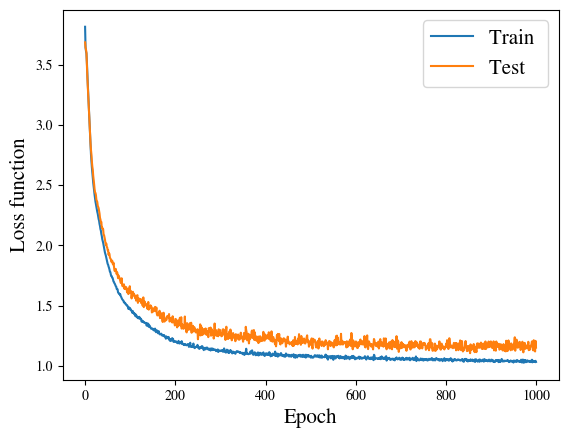

In [ ]:
from tqdm import tqdm

latent_dim = study.best_params['Latent size'] 
emd_dim = study.best_params['Emb size'] 
hidden_dim = study.best_params['Hidden1']
klratio = study.best_params['KL ratio']
lr = study.best_params['lr']  


device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = VariationalAutoEncoder(emb_dim=emd_dim, hidden_dim = hidden_dim ,  latent_dim=latent_dim).to(device)

train_loss_save, test_loss_save = [], []
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
epochs = 1000
for epoch in tqdm(range(epochs)):
    train_loss = train(model, device, train_dataloader, optimizer, loss_fn, klratio=klratio)
    train_loss_save.append(train_loss)
    test_loss = test(model,device,test_dataloader,loss_fn, klratio=klratio)
    test_loss_save.append(test_loss)
train_mse = np.sqrt(np.array(train_loss_save))
test_mse = np.sqrt(np.array(test_loss_save))
plt.plot(train_mse,label="Train ")
plt.plot(test_mse,label="Test ")
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Loss function", fontsize = 15)
plt.legend(loc="best", fontsize = 15)

torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    },'VAE_Intensified.pth')

In [ ]:
sample =  X_discrete_raw[0:4500].to(dtype=torch.long) #  torch.tensor([[14, 30, 42]])
with torch.no_grad():
    # Adjust indexs for embeddings
    f1_idx = sample[:, 0] - 1
    f2_idx = sample[:, 1] - 1
    dw_idx = sample[:, 2] - 1
    col_idx = sample[:,3] - 30
    # Get embeddings
    f1_emb = model.feed1_emb(f1_idx)
    f2_emb = model.feed2_emb(f2_idx)
    dw_emb = model.stagesdw_emb(dw_idx)
    col_emb = model.stagescol_emb(col_idx)

    # Concatenate embeddings 
    h = torch.cat([f1_emb, f2_emb, dw_emb, col_emb], dim=1)
    h_enc = model.encoder_fc(h)

    mu = model.fc_mu(h_enc)
    logvar = model.fc_logvar(h_enc)
    z = model.reparameterize(mu, logvar)
    y_decoded = model.decoder(z)

    # Spplit logits obtained from decoxder for each variable
    f1_dec, f2_dec, dw_dec, col_dec = torch.chunk(y_decoded, 4 , dim=1)
    f1_logits = model.feed1_out(f1_dec)
    f2_logits = model.feed2_out(f2_dec) 
    dw_logits = model.stagesdw_out(dw_dec)
    col_logits = model.stagescol_out(col_dec)


    # Get probabilities using softmax function
    f1_probs = F.softmax(f1_logits, dim=1)
    f2_probs = F.softmax(f2_logits, dim=1)
    dw_probs = F.softmax(dw_logits, dim=1)
    col_probs = F.softmax(col_logits, dim = 1)

    # Get index with the highest probabilitie and adjust thebase to recvoer true discrete value
    f1_discrete = torch.argmax(f1_probs, dim=1) + 1  # Adjsut to 1-based
    f2_discrete = torch.argmax(f2_probs, dim=1) + 1  # Adjsut to 1-based
    dw_discrete = torch.argmax(dw_probs, dim=1) + 1  # Ajustar a 1-based
    col_discrete = torch.argmax(col_probs, dim=1) + 30

# Combine to get x vector and compare with  initial data used.
discrete_values = torch.cat([f1_discrete.unsqueeze(1), f2_discrete.unsqueeze(1),
                            dw_discrete.unsqueeze(1), col_discrete.unsqueeze(1) ], dim=1)
discrete_values